# E10 — Example solutions

These are example solutions for the [E10 notebook on intracellular calcium handling](E10%20—%20Exercises%20on%20Calcium%20Handling.ipynb#3).

## Exercise 1: A Simple Calcium Cycling Model

**Exercise 1a) Linear currents**

The four fluxes become

\begin{align}
J_{\rm entry} &= k_{\rm entry} \left( \rm [Ca^{2+}]_{\rm o} - \rm [Ca^{2+}]_{\rm i} \right), \\ 
J_{\rm rel} &= k_{\rm rel} \left( \rm [Ca^{2+}]_{\rm SR} - \rm [Ca^{2+}]_{\rm i} \right), \\ 
J_{\rm extrusion} &= k_{\rm extrusion} \times  [{\rm Ca}^{2+}]_{\rm i}, \\ 
J_{\rm uptake} &= k_{\rm uptake} \times \rm [Ca^{2+}]_{\rm i}, \\ 
\end{align}

Note that all of these terms become positive the way we have defined them, so we need to add the sign when setting up the derivatives.

**Exercise 1b) Concentration changes**

The cytosol concentration changes with all four fluxes. Entry and release increases concentration, extrusion and uptake into the SR lowers it, so we have
\begin{equation}
\frac{\rm d [Ca^{2+}]_i}{{\rm d}t} = J_{\rm entry} + J_{\rm rel} - J_{\rm extrusion} - J_{\rm uptake},
\end{equation}

For the SR, the sarcolemmal fluxes don't impact it directly, so we only get two terms
\begin{equation}
\frac{\rm d [Ca^{2+}]_{SR}}{{\rm d}t} = \frac{J_{\rm uptake} - J_{\rm rel}}{\gamma}.
\end{equation}

**Exercise 1c) Variable release rate**

\begin{equation}
k_{\rm rel} = \kappa_0 + \kappa_1 \times \frac{\rm [Ca^{2+}]^n_{\rm i}}{K_{\rm d}^n + [{\rm Ca}^{2+}]_{\rm i}^n}
\end{equation}

This equation consists of two terms, the $\kappa_0$ term is simply a constant, and thus represents the "constant" linear release flux. It can be considered a leak term. Then we have the term multiplied by $\kappa_1$, which is the Hill equation. This term will be low for low cytosolic calcium, and then grow in a sinusoidal manner and become saturated.

**Exercise 1d) Implementing the RHS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def rhs(t, y, Cao, k_entry, k_extrusion, k_uptake, kappa0, kappa1, Kd, n, gamma):
    # Split up the state vector
    Cai, CaSR = y    
    
    # Define the linear fluxes
    Jentry = k_entry * (Cao - Cai)
    Jextrusion = k_extrusion * Cai
    Juptake = k_uptake * Cai
    
    # Compute the release rate (CICR)
    k_rel = kappa0 + kappa1 * Cai**n/(Cai**n + Kd**n)
    Jrel = k_rel * (CaSR - Cai)
    
    # Define the derivatives
    dCai_dt = Jentry + Jrel - Jextrusion - Juptake
    dCaSR_dt = (Juptake - Jrel)/gamma
    
    return dCai_dt, dCaSR_dt

**Exercise 1e) Solving the model and plotting the solution**

In [2]:
# Parameters
Cao = 1000 # µM

k_entry = 2e-5 # 1/s
k_extrusion = 0.132 # 1/s
k_uptake = 0.9 # 1/s
kappa0 = 0.013 # 1/s
kappa1 = 0.58 # 1/s
Kd = 0.5 # µM
n = 3.
gamma = 0.24

params = (Cao, k_entry, k_extrusion, k_uptake, kappa0, kappa1, Kd, n, gamma)

In [3]:
# Define initial conditions and parameters needed by solve_ivp
T = (0, 1000)
y0 = (0.08, 4.0)
y0 = (0.1, 4)
params = (Cao, k_entry, k_extrusion, k_uptake, kappa0, kappa1, Kd, n, gamma)

# Solve the ODE
solution = solve_ivp(rhs, T, y0, args=params, max_step=0.1)

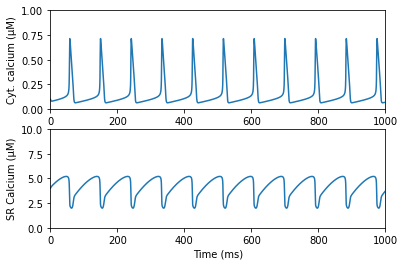

In [4]:
Cai, CaSR = solution.y
t = solution.t

plt.subplot(2, 1, 1)
plt.plot(t, Cai)
plt.ylabel('Cyt. calcium (µM)')
plt.xlim(*T)
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(t, CaSR)
plt.xlabel('Time (ms)')
plt.ylabel('SR Calcium (µM)')
plt.xlim(*T)
plt.ylim(0, 10)
plt.show()

**Exercise 1f) Describing the solution**

We clearly see oscillations in the model. At the beginning, cytosolic calcium is very low. It is then slowly increasing until it seems to hit some sort of threshold and it spikes very rapidly. It then rapidly decays back to roughly the start value. This pattern then repeats with regular spikes of similar amplitude.

As the only non-linear flux term in the model is the CICR release-term, it is clear that the rapid spikes must be caused by the rapid release from the SR that is triggered once cytosolic calcium reaches some threshold.

t is less clear what stops the spike, but seeing as the release rate is purely monotonic (increases with cytosolic calcium), it cannot be any built in inactivation or gating of release. Instead it must be that the SR load is reduced sufficiently that the release current is becoming smaller than the extrusion and uptake currents. These two will in turn be *increased* as cytosolic calcium is high, so this does seem reasonable.

**Exercise 1g) Changes in initial conditions (Widget)**

Playing around with the widget shows the results are more or less compeltely unaffected by the initial conditions. This is because both the cytosolic and SR concentrations are decided by the balances of the four currents, which will tend to their equilibrium quickly in this model. And this equilibrium is not affected by initial conditions.

**Exercise 1h) Plotting the CICR rate**

As this equation is the Hill equation, we need to increase the Hill coefficient $n$ to make the curve steeper. Lowering the $K_{\rm d}$ value will shift the whole sigmoid to lower concentrations (i.e., left in the figure), meaning the "trigger" for CICR happens at lower concentrations.

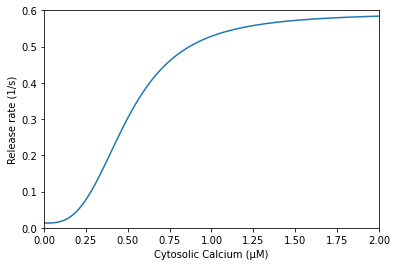

In [5]:
Cai = np.linspace(0, 2, 1001)
k_rel = kappa0 + kappa1 * Cai**n/(Cai**n + Kd**n)

plt.plot(Cai, k_rel)
plt.xlabel('Cytosolic Calcium (µM)')
plt.ylabel('Release rate (1/s)')
plt.axis((0, 2, 0, 0.6))
plt.show()

**Exercise 1i) Exploring the CICR model (Widget)**

* $\kappa_0$ is the constant term. If we want release to be close to zero when there is low cytosolic calcium, this should be low
* $\kappa_1$ decides the magnitude of the calcium-dependent flux. If we want the release flux to be big when it is triggered, this should be high
* $K_{\rm d}$ is the (microscopic) dissociation constant. It decides at what point the release currents gets "triggered". This affects how high we want cytosolic calcium to be before it spikes. It cannot be too low, otherwise release would never turn off.
* $n$ is the Hill coefficient, it decides how steep the sigmoidal function becomes and a very high $n$ would effectively approach a step function. It should be high, as we want a steep and rapid increase in the release flux.


## Exercise 2: Thermodynamic Limits of SERCA

**Exercise 2a) Change in Gibbs Energy**

Gibbs energy is a quantity that combines energy and entropy into a single measure. The first two laws of thermodynamics says that energy must remain constant and entropy will tend to increase in an isolated system. From the expression 
$$G = U + pV - TS,$$
we see that this means that Gibbs energy can only decrease in an isolated system. We have earlier said that this in turn implies that a process where $\Delta G < 0$ can happen spontaneously, a process where $\Delta G > 0$ cannot (as it would break the laws of thermodynamics) and $\Delta G = 0$ would imply thermodynamic equilibrium.

If we have ${\rm [Ca^{2+}]_{SR}} > {\rm [Ca^{2+}]_i}$, then the fraction becomes above unity, and the logarithm becomes a positive number, so we have 

$$\Delta G_{\rm pump} = 2RT \ln\left(\frac{\rm [Ca^{2+}]_{SR}}{\rm [Ca^{2+}]_i}\right)  >  0,$$

Thus this process cannot possibly happen on its own. This should not be surprising. If the SR concentration is higher, moving calcium from the cytosol into the SR means we are moving ions against the concentration gradient, which would never happen on its own. Thus SERCA must be a case of *active* transport, not passive.

**Exercise 2b) Coupling processes**

Because SERCA is an example of active transport, it must gain energy to perform its pumping. This is done by coupling pumping action to ATP. It uses a single ATP per cycle, pumping two calcium ions. Each individual cycle of the pump must fulfill the laws of thermodynamics, and so for each cycle we must have

$$\Delta G_{\rm pump} + \Delta G_{\rm ATP} < 0.$$

Put into simpler english. The equation says that SERCA cannot spend more energy pumping calcium than it harvests from ATP, which is hopefully intuitive.

Where $G_{\rm ATP}$ is the change in Gibbs Energy we get from "spending" a single ATP molecule.


**Exercise 2c) Maximum concentration ratio**

We have

$$\Delta G_{\rm pump} < -\Delta G_{\rm ATP}.$$

Inserting the expression for $\Delta G_{\rm pump}$ yields

$$2RT \ln\left(\frac{\rm [Ca^{2+}]_{SR}}{\rm [Ca^{2+}]_i}\right) < -\Delta G_{\rm ATP}.$$

We now divide by $2RT$ and take the exponential

$$\frac{\rm [Ca^{2+}]_{SR}}  {\rm [Ca^{2+}]_{i}} < {\rm exp}\ \bigg[\frac{\Delta G_{\rm ATP}}{2RT}\bigg].$$

Which in turn gives

$${\rm [Ca^{2+}]_{SR}} < {\rm [Ca^{2+}]_{i}} \times {\rm exp}\ \bigg[\frac{-\Delta G_{\rm ATP}}{2RT}\bigg].$$

And that is what we wanted to show, q.e.d.

Inserting for instance $\Delta G_{\rm ATP} \approx -50$ kJ/mol and $2RT\approx 5.2$ kJ/mol then yields

$$\exp\bigg[\frac{-\Delta G_{\rm ATP}}{2RT}\bigg] = \exp\bigg[\frac{-50}{5.2}\bigg] \approx 15000.$$

Do note however that this answer is highly susceptible to what exact value you pick for $\Delta G_{\rm ATP}$, because it enters into the exponential. If you for instance pick 45 kJ/mol we get almost the third at roughly 5700. It is however clear that the thermodynamical limit is in the ballpark of thousandfolds higher concentration in the SR.

**Exercise 2d) The difference between theory and practice**

A commonly cited statement is that SERCA can maintain a calcium gradient of about 1:7000, i.e., the SR load can be at most 7000-fold higher than the cytosolic calcium. Compare this statement with the theoretical limit you found. If there are differences, discuss why this might be. Does it seem like SERCA is operating at its thermodynamic limit?

We found an estimated theoretical limit of 15000 times higher concentration. While 7000 sounds a lot smaller, as we mentioned the answer is quite sensitive to the ATP energy. But the order of magnitude seems quite correct. And as our lower estimate actually was *below* the experimentally measured gradients, it is clear that SERCA is both quite efficient at using energy from ATP and is indeed operating close to the thermodynamic limit.

This exercise was mainly meant to: (1) give you some experience using Gibbs energy to make estimates, and (2) see that SERCA is capable of maintaing massive concentration gradients across the SR membrane. The exact ratio is not that important.

<a id="3"></a>
## Exercise 3: Thermodynamics of the NCX

**Exercise 3a) Passive or active transport? (Discussion)**

Passive ion transport is transport that occurs spontaneously, without being driven by an external driving force, like ion channel transport. Active transport is transport that does not occur spontaneously, but that must be driven by an external force.

The NCX as a whole is an example of an active transport, as it manages to drive calcium *against* its concentration gradient. But it does this by coupling the active transport to the *passive* transport of sodium. So in a sense, it makes sense to say that NCX is a combination of passive and active transport. In its forward it couples passive sodium transport to active calcium transport. And in the reverse mode it will be flipped, passive transport of calcium and active transport of sodium.

**Exercise 3b) Gibbs energy**

For one transported calcium ion, three sodium ions are moved in the opposite direction, which explains both the sign and the factor of 3. No ATP is expended, so there is no ATP term.

$$\Delta G_{\rm NCX} = \Delta G_{\rm Ca} - 3\Delta G_{\rm Na}.$$

**Exercise 3c) Enter the Nernst potentials**

We then get (note: $z_{\rm Ca} = 2$)

$$\Delta G_{\rm Ca} = 2F \big( E_{\rm Ca} - V \big).$$

and 

$$\Delta G_{\rm Na} = F \big( E_{\rm Na} - V \big).$$

Inserting these gives

$$\Delta G_{\rm NCX} = 2F \big( E_{\rm Ca} - V \big) - 3F \big( E_{\rm Na} - V \big)$$

**Exercise 3d) Reversial potential**

We want to solve the following equation for $V$.

$$\Delta G_{\rm NCX} = 2F \big( E_{\rm Ca} - V \big) - 3F \big( E_{\rm Na} - V \big) = 0.$$

We can divide by $F$, leaving

$$2 \big( E_{\rm Ca} - V \big) = 3 \big( E_{\rm Na} - V \big).$$

Which in turn gives,

$$V = E_{\rm NCX} = 3E_{\rm Na} - 2E_{\rm Ca}.$$

Q.e.d.

We now have found an expression for the NCX reversial potential. When $V > E_{\rm NCX}$, calcium will actually tend to *enter* the cell, but if $V < E_{\rm NCX}$ then calcium is leaving the cell through the NCX.

**Exercise 3e) Reversial potential in mV**

We get

$$E_{\rm NCX} = 3\times 80 {\rm\ mV} - 2\times 120 {\rm\ mV} = 0 {\rm\ mV}.$$

Note that this is not the precise value of $E_{\rm NCX}$ in practice, as $E_{\rm Ca}$ typically changes a lot during the action potential. But it gives us a ballpark figure which happens to be roughly 0 mV. 

**Exercise 3f) The NCX during the action potential**

We have found that $E_{\rm NCX} \approx 0$ mV. This means that at rest we have $V < E_{\rm NCX}$, the NCX is operating in forward mode, allowing calcium to leave the cell and sodium to enter it. However, when an action potential fires, the membrane potential increases above the reversal potential of the NCX. This means that as the L-type calcium channels open and allow calcium into the cell, the NCX isn't pumping calcium out, it is allowing it in as well. When the action potential plateaus, we are close to $V \approx E_{\rm NCX}$ and we expect little NCX activity, in either direction. As the membrane potential returns to rest, calcium is pumped by NCX effectively.

The fact that the NCX is operating in reverse mode during the spike, and then is inactive during the plateau phase is actually quite a "clean design", as it means the NCX can effectively remove calcium from the cell when needed, but doesn't get in the way of a quick and efficient calcium influx when this is needed to produce the calcium transient.